# 필요 package

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import os
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)

from selenium import webdriver as wd
import time
from bs4 import BeautifulSoup
import requests
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor

import geopy.distance


# 크롤링 코드

In [ ]:
browser = wd.Chrome("../../software/chromedriver.exe")
browser.get("https://www.airport.co.kr/jeju/extra/flightSchedule/flightDomesticList/layOut.do?cid=2015120718125215729&menuId=653")

element = browser.find_element_by_xpath('//*[@id="selType"]')
element.click()

element = browser.find_element_by_xpath('//*[@id="selType"]/option[2]')
element.click()

element = browser.find_element_by_xpath('//*[@id="findDate"]')
element.clear()
element.send_keys("2019-10-27")

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[2]/form/div/div[2]/button')
element.click()

air_head = []

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/thead')

for i in range(1, 264):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
for i in range(1, 272):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[4]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
test = pd.DataFrame(data = air_content, columns = air_head)

test["제주 관련 시간"] = 0
test["제주 시간 관련"] = 0

for i in range(len(test)):
    if test["출발지"][i] == "제주":
        test["제주 관련 시간"][i] = test["출발시간"][i]
    else:
        test["제주 관련 시간"][i] = test["도착시간"][i]
        
test.drop("편명", axis = 1, inplace = True)

test.to_csv("../data/result_air.csv")

# 데이터 불러오기

In [2]:
# 데이터 불러오기
bus_df = pd.read_csv("bus_train_data.csv")
weather_df = pd.read_csv("jeju_weather.csv")
air_df = pd.read_csv("result_air.csv")

In [3]:
weather_df["date"] = "date"

In [4]:
for i in range(len(weather_df["date_group"])):
    weather_df["date"][i] = weather_df["date_group"][i].replace("일", "")
    weather_df["date"][i] = "2019-10-{0}".format(weather_df["date"][i])
    
weather_df = weather_df.rename(columns = {"time_group" : "now_arrive_time"})
weather_df = weather_df.drop(weather_df.columns[[0,2,5,7,8,9,10,11]],  axis = 1)

bus_weather_df = pd.merge(bus_df, weather_df)

In [5]:
temp = air_df.groupby(["날짜", "시간"]).count()
temp = pd.DataFrame(temp["항공사"].unstack())

data_list = []

for i in range(len(temp.index)):
    for j in range(len(temp.columns)):
        data_list.append([temp.index[i],temp.columns[j], temp.iloc[i][j]])
        
air_df = pd.DataFrame(data_list)

air_df.columns = ["date", "now_arrive_time", "count_air"]

df = pd.merge(bus_weather_df, air_df)

train = df

# 데이터 전처리

In [6]:
# 날짜 전처리
train['date_group']='weekday' #date_group 변수를 미리 생성

train.loc[ (train['date'] == '2019-10-19') | (train['date'] == '2019-10-20') | (train['date'] == '2019-10-26') | (train['date'] == '2019-10-27') ,['date_group'] ]= 'weekend' # 주말
train = pd.get_dummies(train,columns=['date_group'])

# 19, 20, 26, 27

In [7]:
train["date_day"] = "monday"
train.loc[(train["date"] == "2019-10-15") | (train["date"] == "2019-10-22"), ["date_day"]] = "Tuesday"
train.loc[(train["date"] == "2019-10-16") | (train["date"] == "2019-10-23"), ["date_day"]] = "Wednesday"
train.loc[(train["date"] == "2019-10-17") | (train["date"] == "2019-10-24"), ["date_day"]] = "Thurday"
train.loc[(train["date"] == "2019-10-18") | (train["date"] == "2019-10-25"), ["date_day"]] = "Friday"
train.loc[(train["date"] == "2019-10-19") | (train["date"] == "2019-10-26"), ["date_day"]] = "Saturday"
train.loc[(train["date"] == "2019-10-20") | (train["date"] == "2019-10-27"), ["date_day"]] = "Sunday"

train = pd.get_dummies(train, columns=["date_day"])

In [8]:
# 강수량 전처리
train['rain']=0
train.loc[ (train['누적강수량(mm)']!=0) ,['rain'] ] = 1

In [9]:
# 시간 전처리
train['time_group']='group' #time_group 변수를 미리 생성

train.loc[ (train['now_arrive_time']>='05시') & (train['now_arrive_time']<='06시') ,['time_group'] ]= 'dawn' # 05~06시
train.loc[ (train['now_arrive_time']>='07시') & (train['now_arrive_time']<='08시') ,['time_group'] ]= 'morning' #07~08시
train.loc[ (train['now_arrive_time']>='09시') & (train['now_arrive_time']<='17시') ,['time_group'] ]= 'afternoon' #09~17시
train.loc[ (train['now_arrive_time']=='18시') ,['time_group'] ]= 'dinner' #18시
train.loc[ (train['now_arrive_time']>='19시') & (train['now_arrive_time']<='22시') ,['time_group'] ]= 'night' #09~17시

train = pd.get_dummies(train,columns=['time_group'])

In [10]:
# 풍속
w = pd.DataFrame(train['풍속(m/s)'].groupby([train['date'],train['now_arrive_time']]).mean())
train['wind'] = 0
train.loc[(train['풍속(m/s)'] > w.mean()[0]) ,['wind']] = 1

In [11]:
temp_list = []
train = train.drop(train[train["next_arrive_time"] > 1000].index)
max = train.distance.max()
min = train.distance.min()

for i in train.distance:
    temp_list.append((i - min) / (max - min))
train.distance = temp_list

In [12]:
temp_list = []

max = train.count_air.max()
min = train.count_air.min()

for i in train.count_air:
    temp_list.append((i - min) / (max - min))
train.count_air = temp_list

In [13]:
train = train.drop(train[["누적강수량(mm)", "풍속(m/s)"]], axis = "columns")

In [14]:
train['distance_line']=[ geopy.distance.vincenty( (i,j), (k,l) ).km 
 for i,j,k,l in list( zip( train['now_latitude'],train['now_longitude'],train['next_latitude'],train['next_longitude'] ) ) ]

In [15]:
train.wind.max()

1

# 데이터 학습 및 예측

In [16]:
train_x = train.drop(train[["id", "date","route_id", "vh_id", "route_nm", "now_latitude", "now_longitude", "now_station", "now_arrive_time", "next_station", "next_arrive_time", "next_latitude", "next_longitude", "기온(°C)", "wind"]], axis = "columns")
train_y = train.next_arrive_time

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [18]:
rf = RandomForestRegressor(random_state=1217)
rf.fit(X_train,y_train)
result = 0
predict = rf.predict(X_test)
print((mean_squared_error(predict, y_test))**0.5)

39.998470367354365


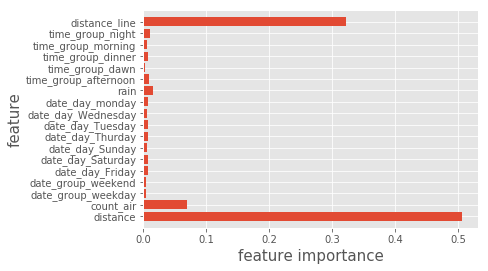

In [19]:
n_feature = train_x.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

input_var= list( train_x.columns[:] )
plt.barh(index, rf.feature_importances_, align='center') 
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [20]:
gbrt = GradientBoostingRegressor(max_depth=3, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 300):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print((val_error)**0.5)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

63.658183968794496
61.48092269229117
59.7313644758964
58.15074867555895
56.83152189798721
55.80157641955649
54.83944455639485
53.98722673860451
53.26241912710919
52.62191974609212
52.13138120178521
51.67485582874618
51.26659597467779
50.92483572544208
50.652549447332746
50.39312384530687
50.1785078848625
49.95460089184687
49.768114662343905
49.58723937532193
49.4009071468426
49.221498334672695
49.11845002474909
48.927459174332874
48.84587557579734
48.714101872924246
48.60830239316496
48.22284356809153
48.14703326822489
47.845074310992096
47.696757314288284
47.65729312935969
47.434982892785285
47.32727633516333
47.305725327414414
47.19860419053541
46.93766738873419
46.868693231308846
46.8066182557691
46.708884058301635
46.626878341427044
46.609838686363666
46.51243866688832
46.44228201727367
46.428688518570205
46.41445298843681
46.33954883323209
46.22333972646336
46.10015945931746
46.03158816576641
45.983277253008225
45.97391004554395
45.87289154510794
45.67858823165494
45.6549650557580

KeyboardInterrupt: 

63.38967549367167
